# **Определение нелояльных клиентов оператора связи**

### Описание
Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. 

Чтобы заранее находить таких пользователей заказчику нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

Заказчик требует, чтобы значение метрики ROC-AUC на тестовой выборке было не менее 0.8

### Цель работы
Построить модель машинного обучения, прогнозирующую клиентов, готовых разорвать договор.

### Ход работы
1. Загрузка и предобработка данных;
2. Исследовательский анализ данных;
3. Подготовка данных и обучение модели машинного обучения;
4. Интерпретация данных;
5. Общий вывод и рекомендации заказчику.

**Импорты**

In [1]:
!pip install --upgrade pandas
!pip install --upgrade phik
!pip install --upgrade lightgbm

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from phik.report import plot_correlation_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

**Установка глобальных переменных**

In [3]:
RANDOM_STATE = 231224
TEST_SIZE = 0.25
ACTUAL_DATE = '2020-02-01'

**Загрузка датасетов**

## **Предобработка**

In [5]:
person.info()
person.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No


In [6]:
contracts.info()
contracts.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04


In [7]:
internet.info()
internet.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No


In [8]:
phone.info()
phone.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No


Столбцы имеют неверные наименования. Исправление.

In [9]:
person.columns  = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
contracts.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
                     'payment_method', 'monthly_charges', 'total_charges']
internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
phone.columns = ['customer_id', 'multiple_lines']

Некоторые данные имеют неверный формат. Исправление.

In [10]:
contracts['total_charges'] = contracts['total_charges'].apply(lambda x: re.sub('[^0-9.]', '0', x)).astype('float')
contracts['total_charges'] = contracts['total_charges'].replace(0, contracts['total_charges'].median())

**Проверка на дубликаты**

In [11]:
print(f'Количество дубликатов person: {person.duplicated().sum()}')
print(f'Количество дубликатов contracts: {contracts.duplicated().sum()}')
print(f'Количество дубликатов internet: {internet.duplicated().sum()}')
print(f'Количество дубликатов phone: {phone.duplicated().sum()}')

Количество дубликатов person: 0
Количество дубликатов contracts: 0
Количество дубликатов internet: 0
Количество дубликатов phone: 0


**Проверка на уникальность пользователей**

In [12]:
def dubl(df):
    print(f"Записи пользователей уникальны: {'Да' if df.shape[0] == len(df['customer_id'].unique()) else 'Нет'}")

dubl(person)
dubl(contracts)
dubl(internet)
dubl(phone)

Записи пользователей уникальны: Да
Записи пользователей уникальны: Да
Записи пользователей уникальны: Да
Записи пользователей уникальны: Да


***
**Вывод:**
Выполнена предобработка данных:
- Данные осмотрены;
- Исправлены наименования столбцов в датасетах;
- Исправлены типы данных в датасетах;
- Выполнена проверка на дубликаты;
- Выполнена проверка на уникальност идентификаторов пользователей.
***

## **Исследовательский анализ данных**

**Генерация новых признаков**

Целевой признак

In [13]:
contracts['target'] = contracts['end_date'].apply(lambda x: 1 if x != 'No' else 0)

Генерация дополнительных признаков

In [14]:
contracts['end_date'] = pd.to_datetime(contracts['end_date'].replace('No', ACTUAL_DATE))
contracts['contract_length_months'] = ((contracts['end_date'] - contracts['begin_date']).dt.days.astype(int) / 30).round(2)
contracts['payments_per_month'] = (contracts['total_charges'] / contracts['contract_length_months']).round(2)
contracts['payments_per_month'] = contracts['payments_per_month'].apply(lambda x: 0 if x == float('inf') else x).sort_values()

In [15]:
contracts.isna().sum()

customer_id               0
begin_date                0
end_date                  0
type                      0
paperless_billing         0
payment_method            0
monthly_charges           0
total_charges             0
target                    0
contract_length_months    0
payments_per_month        0
dtype: int64

**Слияние датафреймов**

In [16]:
data = person.merge(contracts, on='customer_id', how='left')
data = data.merge(internet, on='customer_id', how='left')
data = data.merge(phone, on='customer_id', how='left')

In [17]:
data.info()
for x in data.columns.tolist():
    print(f"\nНазвание: {x}, Уникальные значения: {data[x].unique()}, количество: {len(data[x].unique())}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             7043 non-null   object        
 1   gender                  7043 non-null   object        
 2   senior_citizen          7043 non-null   int64         
 3   partner                 7043 non-null   object        
 4   dependents              7043 non-null   object        
 5   begin_date              7043 non-null   datetime64[ns]
 6   end_date                7043 non-null   datetime64[ns]
 7   type                    7043 non-null   object        
 8   paperless_billing       7043 non-null   object        
 9   payment_method          7043 non-null   object        
 10  monthly_charges         7043 non-null   float64       
 11  total_charges           7043 non-null   float64       
 12  target                  7043 non-null   int64   

Типы данных столбцов изменились. Также появились пропуски. Эти данные о наличии услуг. Их можно заполнить значениями "No", так как из-за отсутствия пользователей в этом датафрейме можно утверждать, что пользователю не оказывались эти услуги.

**Заполнение пропусков и изменение типов данных**

In [18]:
for col in data[internet.columns.tolist()]:
    data[col] = data[col].fillna('No')
data['multiple_lines'] = data['multiple_lines'].fillna('No')

**Проверка на пропуски**

In [19]:
data.isna().sum()

customer_id               0
gender                    0
senior_citizen            0
partner                   0
dependents                0
begin_date                0
end_date                  0
type                      0
paperless_billing         0
payment_method            0
monthly_charges           0
total_charges             0
target                    0
contract_length_months    0
payments_per_month        0
internet_service          0
online_security           0
online_backup             0
device_protection         0
tech_support              0
streaming_tv              0
streaming_movies          0
multiple_lines            0
dtype: int64

Пропуски отсутствуют

**Разделение выборок**

In [20]:
X = data.drop(['target', 'customer_id', 'begin_date', 'end_date'], axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

**Корреляционный анализ**

In [21]:
intrerval_cols = [x for x in X_train.columns.tolist() if len(X_train[x].unique()) > 10]

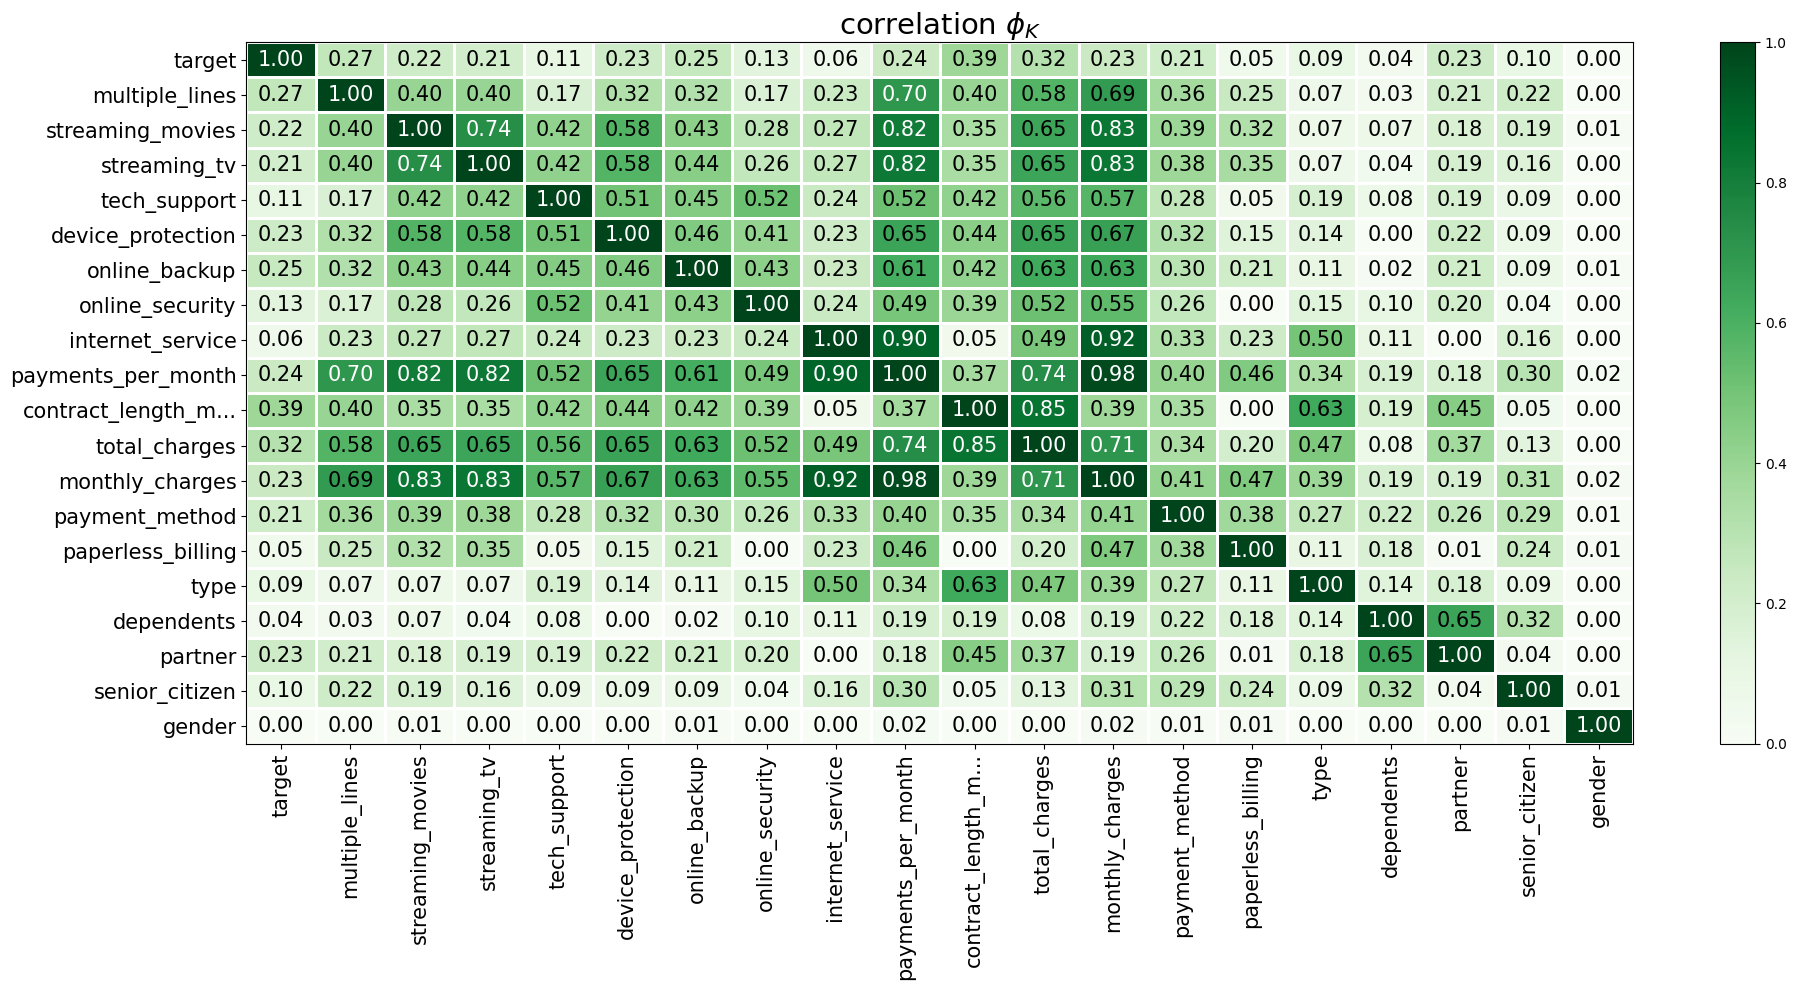

In [22]:
phik_overview = X_train.join(y_train).phik_matrix(interval_cols=intrerval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, 
    vmax=1, 
    color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 10)
)

**Удаление неинформативных данных на основании результатов матрицы корреляций**

In [23]:
to_drop = phik_overview[phik_overview['target'] <= 0.15]['target'].index.tolist()
X_train = X_train.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1);
print(f'Удалены признаки: {to_drop}.\nВсего удалено {len(to_drop)} признаков.')

Удалены признаки: ['gender', 'senior_citizen', 'dependents', 'type', 'paperless_billing', 'internet_service', 'online_security', 'tech_support'].
Всего удалено 8 признаков.


**Анализ распределений признаков**

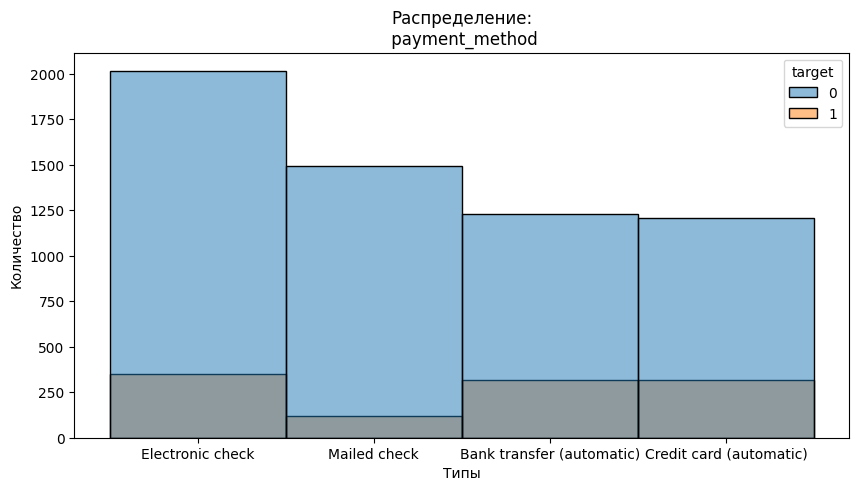

In [24]:
plot_data = data.drop(to_drop, axis=1).drop(['begin_date', 'end_date', 'customer_id'], axis=1)

binar = [col for col in plot_data if len(plot_data[col].unique()) <= 2 and col!='target']
col = plot_data.select_dtypes(include='number').drop('target', axis=1).columns.tolist()
cat = plot_data.drop(binar, axis=1).drop('target', axis=1).select_dtypes(exclude='number').columns.tolist()

for column in cat:
    plt.figure(figsize=(10, 5))
    sns.histplot(
        plot_data, 
        x=column, 
        hue="target"
    ).set(
        title=f'Распределение:\n {column}', 
        xlabel='Типы', 
        ylabel='Количество'
    );

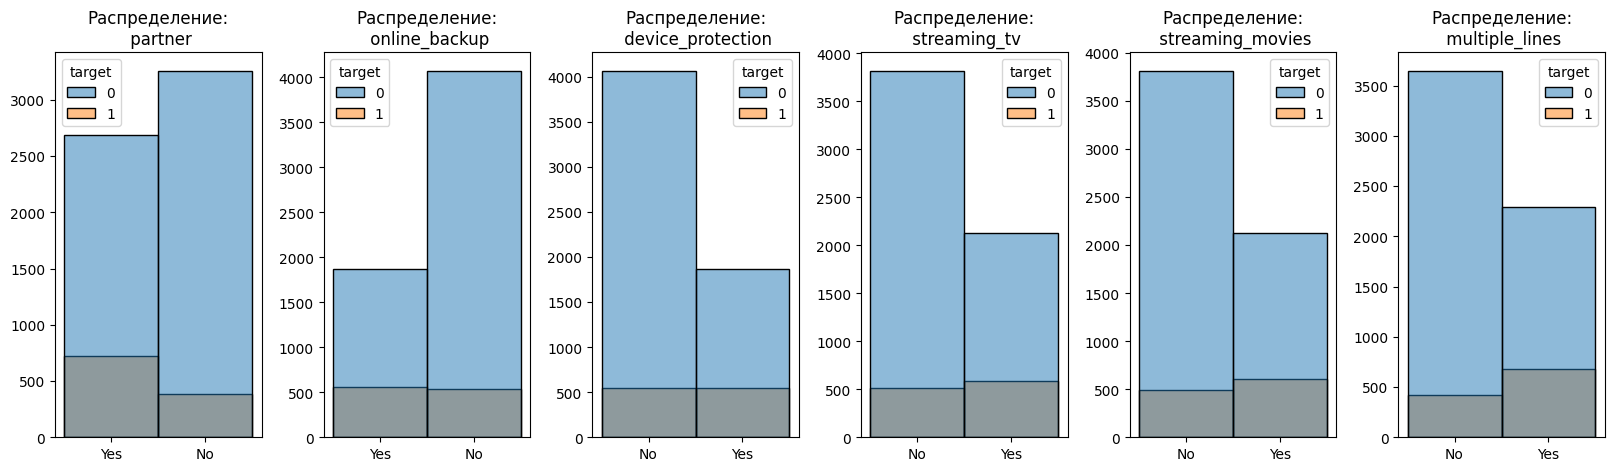

In [25]:
fig, axes = plt.subplots(ncols=len(binar), figsize=(20, 5)) 
plt.subplots_adjust(wspace=0.3, hspace=1)
for num, column in enumerate(binar):
    sns.histplot(
        plot_data,
        x=column, 
        hue='target', 
        ax=axes[num]
    ).set(
        title=f'Распределение:\n {column}', 
        xlabel='', 
        ylabel=''
    );

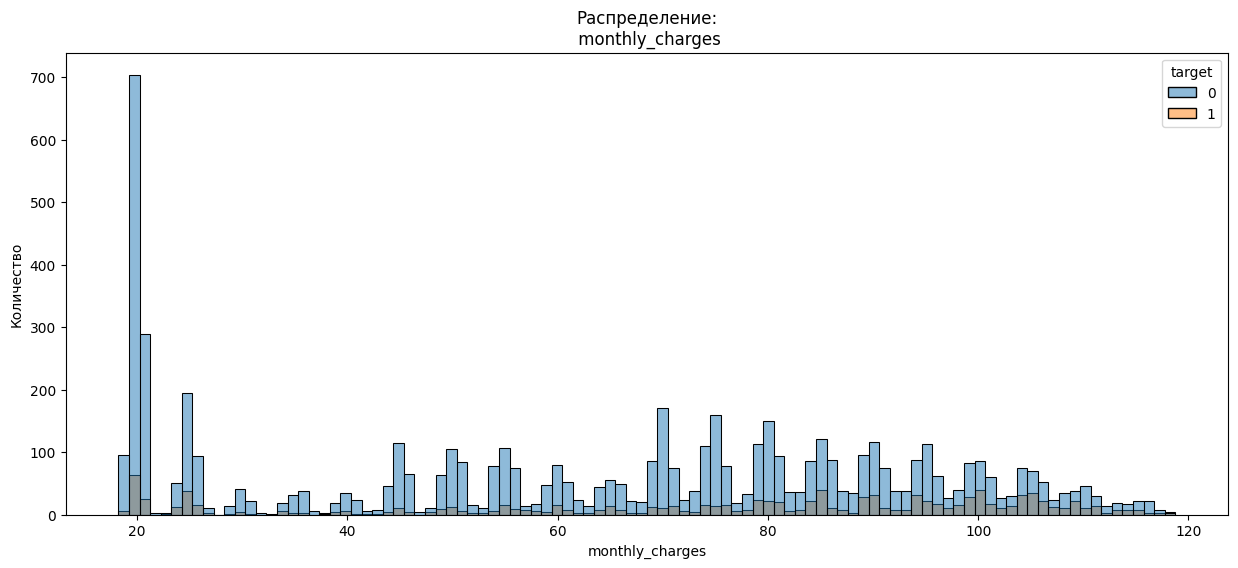

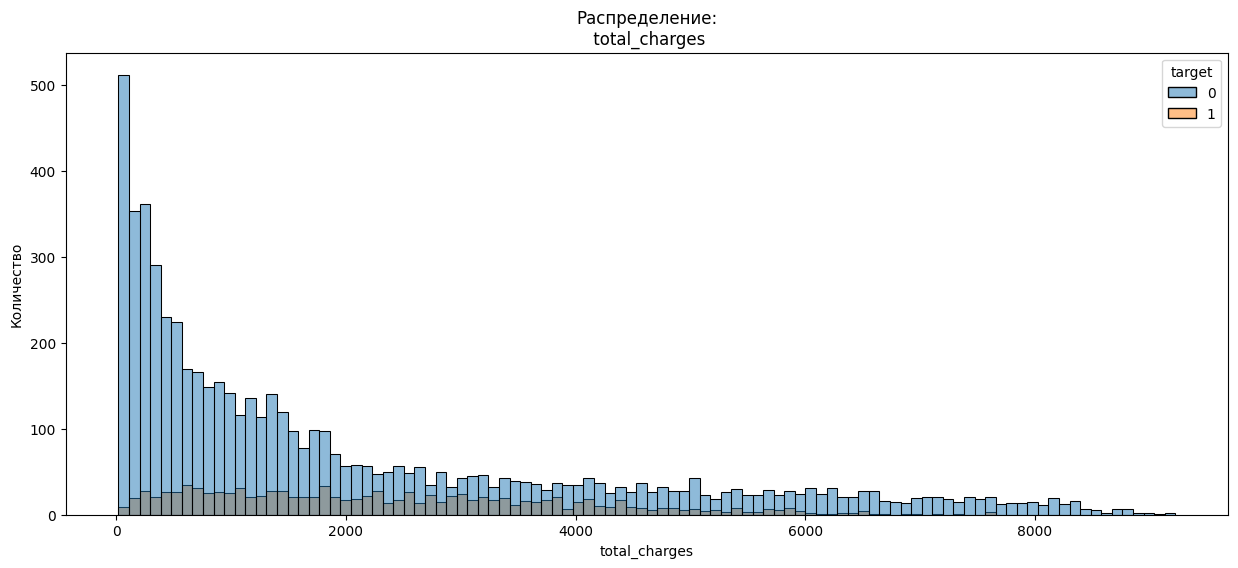

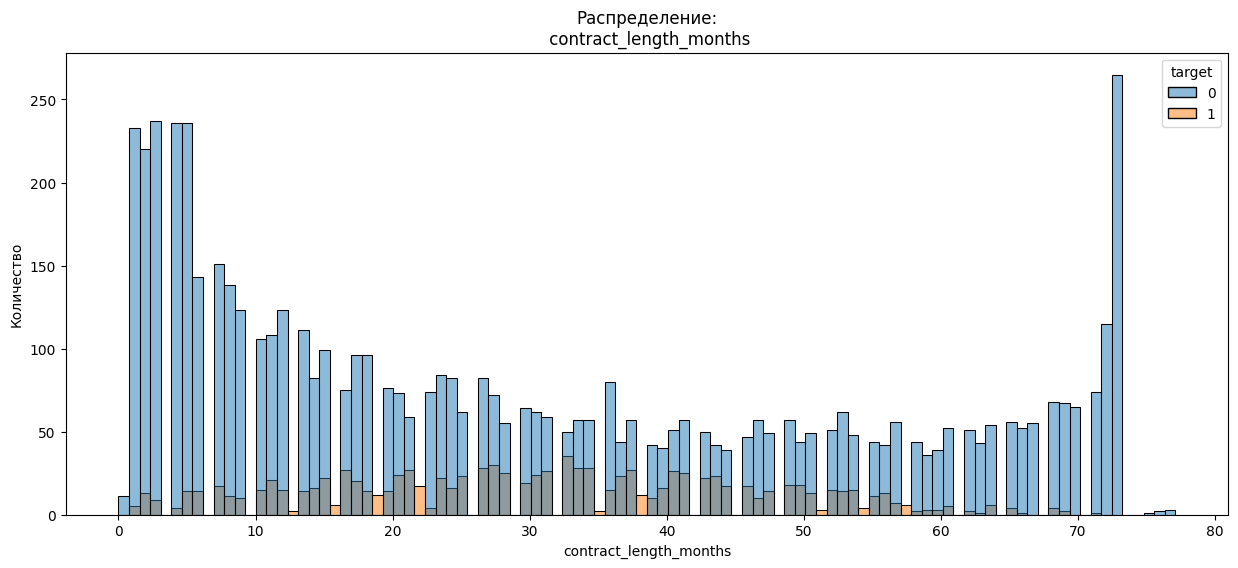

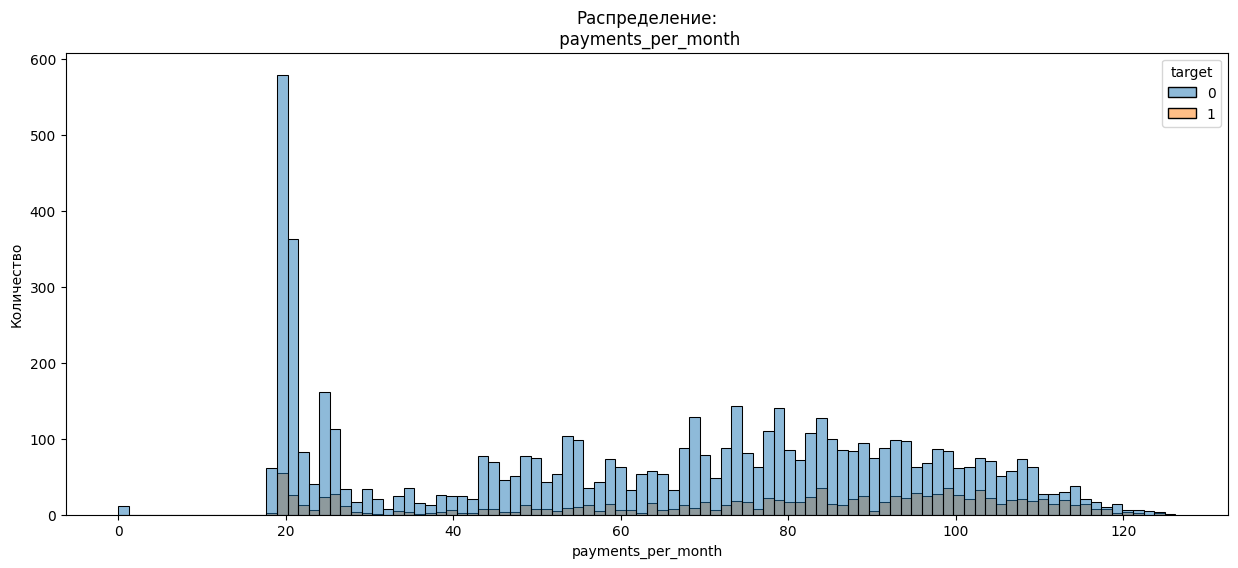

In [26]:
for column in col:
    plt.figure(figsize=(15, 6))
    sns.histplot(
        plot_data, 
        x=column, 
        hue='target', 
        bins=100
    ).set(
        title=f'Распределение:\n {column}', 
        ylabel='Количество')
    plt.show()

***
**Вывод:**
- Описание наиболее вероятного среднестатистического **лояльного** пользователя:
    - предпочитает неавтоматические электронные чеки при оплате;
    - одинокий;
    - не нуждается в облачном хранилище, антивирусе, стриминговом телевидении и подключении к многоканальному телефону.
    - с общей внесённй оплатой до 4000;
    - со сроком действия контракта до 20 и свыше 70 месяцев;
- Описание наиболее вероятного среднестатистического **нелояльного** пользователя:
    - не любит почтовые чеки;
    - с семьёй;
    - немного более предпочитающий стриминговое телевидение, онлайн фильмы и облачное хранилище;
    - подключенный к многоканальному телефону;
    - с общей внесённй оплатой до 4000;
    - со сроком действия контракта от 20 до 55 месяцев.
***

## **Подготовка данных и обучение модели**

**Пайплайн подготовки данных**

In [27]:
preprocessor = ColumnTransformer(transformers=[
    ('ordinal_encoding_cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), cat),
    ('ordinal_encoding_binar', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), binar),
    ('col_scaling', StandardScaler(), col)
])

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('models', LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

**Выбор гиперпараметров моделей.**

In [28]:
param_grid = [
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': range(80, 150, 10),
        'models__num_leaves': range(25, 37),
        'models__boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
        'preprocessor__col_scaling': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(1, 20),
        'models__criterion': ['gini', 'entropy', 'log_loss'],
        'preprocessor__col_scaling': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__solver': ['lbfgs', 'saga', 'liblinear', 'newton-cholesky'],
        'preprocessor__col_scaling': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

**Применение параметров**

In [29]:
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)

**Обучение**

In [30]:
grid.fit(X_train, y_train)

C:\Users\Xellos-san\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1260 fits failed out of a total of 5955.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1260 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Xellos-san\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Xellos-san\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

[LightGBM] [Info] Number of positive: 819, number of negative: 4463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ordinal_encoding_cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=nan),
                                                                         ['payment_method']),
                                                                        ('ordinal_encoding_binar',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=nan),
                                                                         ['partner',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'st...
                          'models__criterion': ['gini', 'entropy', 'log_loss'],
                          'models__max_depth': range(1, 20),
                          'preprocessor__col_scaling': [StandardScaler(),
                                                        MinMaxScaler(),
                                                        'passthrough']},
                         {'models': [LogisticRegression(class_weight='balanced',
                                                        random_state=231224)],
                          'models__solver': ['lbfgs', 'saga', 'liblinear',
                                             'newton-cholesky'],
                          'preprocessor__col_scaling': [StandardScaler(),
                                                        MinMaxScaler(),
                                                        'passthrough']}],
             scoring='roc_auc')

**Вывод метрик**

In [31]:
print(f'Метрика roc-auc на обучающей выборке: {round(grid.best_score_, 2)}')
print(f'Метрика roc-auc на тестовой выборке: {round(roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1]), 2)}')

Метрика roc-auc на обучающей выборке: 0.88
Метрика roc-auc на тестовой выборке: 0.85


***
**Вывод:**
- Построен пайплайн для подготовки данных к обучению;
- Поиск лучшего значения метрики вёлся из трёх моделей:
    - Логистическая регрессия;
    - Древо решений;
    - Градиентный бустинг.
- Для каждой модели подбирались как минимум 2 гиперпараметра;
- Лучшее значение метрики показала модель Градиентного бустинга;
- Значение лучшей метрики на тестовой выборке составило 0.85.
***

## **Интерпретация данных**

In [125]:
importances = pd.DataFrame(data=[grid.feature_names_in_, grid.best_estimator_.named_steps['models'].feature_importances_.tolist()]).T
importances.columns = ['признак', 'значение']
importances = importances.sort_values(by='значение', ascending=False).set_index('признак')

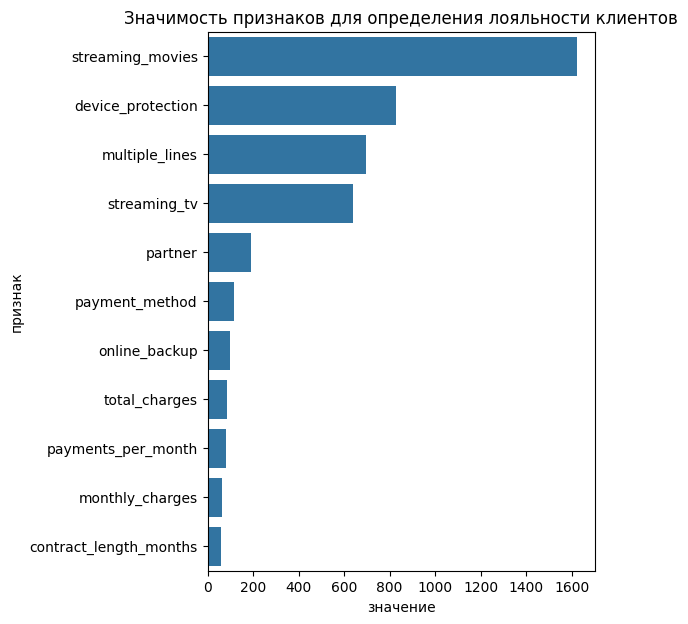

In [127]:
plt.figure(figsize=(5, 7))
sns.barplot(importances, x='значение', y=importances.index, orient='h').set(title='Значимость признаков для определения лояльности клиентов');

***
**Вывод:**
- Определены количественные значения важности признаков для определения лояльности клиентов;
- Построен наглядный график сравнения важности признаков
- Значимые признаки:
    - онлайн-кинотеатр;
    - антивирус;
    - многоканальный телефон;
    - каталог фильмов;
    - семейное положение.
***

## **Вывод и рекомендации**

### Вывод

- Все планируемые шаги выполнены;
- Выполнена предобработка данных:
    - Данные обследованы;
    - Исправлены наименования столбцов в датасетах;
    - Исправлены типы данных в датасетах;
    - Выполнена проверка на дубликаты;
    - Выполнена проверка на уникальност идентификаторов пользователей.
- Выполнен исследовательский анализ данных:
    - Сгенерированы новые признаки:
        - длительность контракта в месяцах;
        - среднемесячный чек.
    - Сформировано описание портрета среднестатистического **лояльного** пользователя:
        - предпочитает неавтоматические электронные чеки при оплате;
        - одинокий;
        - не нуждается в облачном хранилище, антивирусе, стриминговом телевидении и подключении к многоканальному телефону.
        - с общеми расходами до 4000;
        - со сроком действия контракта до 20 и свыше 70 месяцев;
    - Сформировано описание портрета среднестатистического **нелояльного** пользователя:
        - не любит почтовые чеки;
        - с семьёй;
        - предпочитающий стриминговое телевидение, онлайн фильмы и облачное хранилище;
        - подключенный к многоканальному телефону;
        - с общеми расходами до 4000;
        - со сроком действия контракта от 20 до 55 месяцев.    
- Выполнено обучение моделей с поиском лучших гиперпараметров:
    - Построен пайплайн для подготовки данных к обучению;
    - Поиск лучшего значения метрики вёлся из трёх моделей:
        - Логистическая регрессия;
        - Древо решений;
        - Градиентный бустинг.
    - Для обучения использовались признаки:
        - онлайн-кинотеатр;
        - антивирус;
        - многоканальный телефон;
        - стриминговое телефидение;
        - семейное положение;
        - метод оплаты;
        - облачное хранилище файлов для резервного копирования данных;
        - общие расходы абонента;
        - среднемесячный чек;
        - месячная платеж абонента;
        - длительность контракта в месяцах;
    - Лучшее значение метрики показала модель Градиентного бустинга;
    - Значение лучшей метрики на тестовой выборке составило 0.85, что соответствует требованиям клиента.
- Определены количественные значения важности признаков для определения лояльности клиентов;
- Построен наглядный график сравнения важности признаков;
- Значимые признаки для обучения модели:
    - онлайн-кинотеатр;
    - антивирус;
    - многоканальный телефон;
    - стриминговое телевидение;
    - семейное положение.

### Рекомендации заказчику:

Так как наиболее значимыми признаками являются онлайн-кинотеатр, антивирус, стриминговое телевидение и многоканальный телефон,
для удержания нелояльных пользователей рекомендуется предлагать скидки, промокоды или иные методы стимулирования продаж для этих сервисов. Также есть вероятность, что у пользователей возникают проблемы с этими сервисами, по этому с целью улучшить их качество, рекомендуется получить обратную связь от  потенциально нелояльных пользователей.